In [1]:
import pickle

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns
import ssl
import tensorflow as tf
from scipy.stats import skew, kurtosis
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical


ssl._create_default_https_context = ssl._create_unverified_context

2024-11-17 22:07:58.312915: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 22:07:58.316095: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-17 22:07:58.325968: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731899278.342937    7116 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731899278.347795    7116 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-17 22:07:58.364139: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

# Entrenamiento de red neuronal convolucional sin hacer uso de las estadísticas de las distribuciones de los histogramas

In [2]:
with open('data.pickle', 'rb') as f:
    loaded_data = pickle.load(f)

# Acceder a las variables desde el diccionario cargado

val_data = loaded_data["val_data"]
train_data = loaded_data["train_data"]
test_data = loaded_data["test_data"]

val_labels = loaded_data['val_labels']
val_images = loaded_data['val_images']
test_images = loaded_data['test_images']
test_labels = loaded_data['test_labels']
balanced_train_images = loaded_data['balanced_train_images']
balanced_train_labels = loaded_data['balanced_train_labels']
train_detailed_stats = loaded_data["train_detailed_stats"]
val_detailed_stats = loaded_data["val_detailed_stats"]
test_detailed_stats = loaded_data["test_detailed_stats"]

print("Datos cargados exitosamente desde 'data.pickle'")

Datos cargados exitosamente desde 'data.pickle'


In [3]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(set(balanced_train_labels)), activation='softmax')
])
# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Entrenar el modelo
history = model.fit(
    balanced_train_images,
    balanced_train_labels,
    validation_data=(val_images, val_labels),
    epochs=5,
    batch_size = 16
)

/tmp/ipykernel_7116/3222804077.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(
2024-11-17 22:08:02.358127: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/5


2024-11-17 22:08:04.476332: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1311768576 exceeds 10% of free system memory.
2024-11-17 22:08:09.276341: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-11-17 22:08:09.323091: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 33554432 exceeds 10% of free system memory.
2024-11-17 22:08:09.347268: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 100663296 exceeds 10% of free system memory.
2024-11-17 22:08:09.380295: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 102242304 exceeds 10% of free system memory.


105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 353ms/step - accuracy: 0.5536 - loss: 1.1674 - val_accuracy: 0.8160 - val_loss: 0.3787
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 355ms/step - accuracy: 0.9182 - loss: 0.2682 - val_accuracy: 0.8640 - val_loss: 0.3471
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 38s 365ms/step - accuracy: 0.9567 - loss: 0.1287 - val_accuracy: 0.9200 - val_loss: 0.1732
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - accuracy: 0.9837 - loss: 0.0652 - val_accuracy: 0.8800 - val_loss: 0.2769
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 387ms/step - accuracy: 0.9869 - loss: 0.0496 - val_accuracy: 0.9600 - val_loss: 0.1546


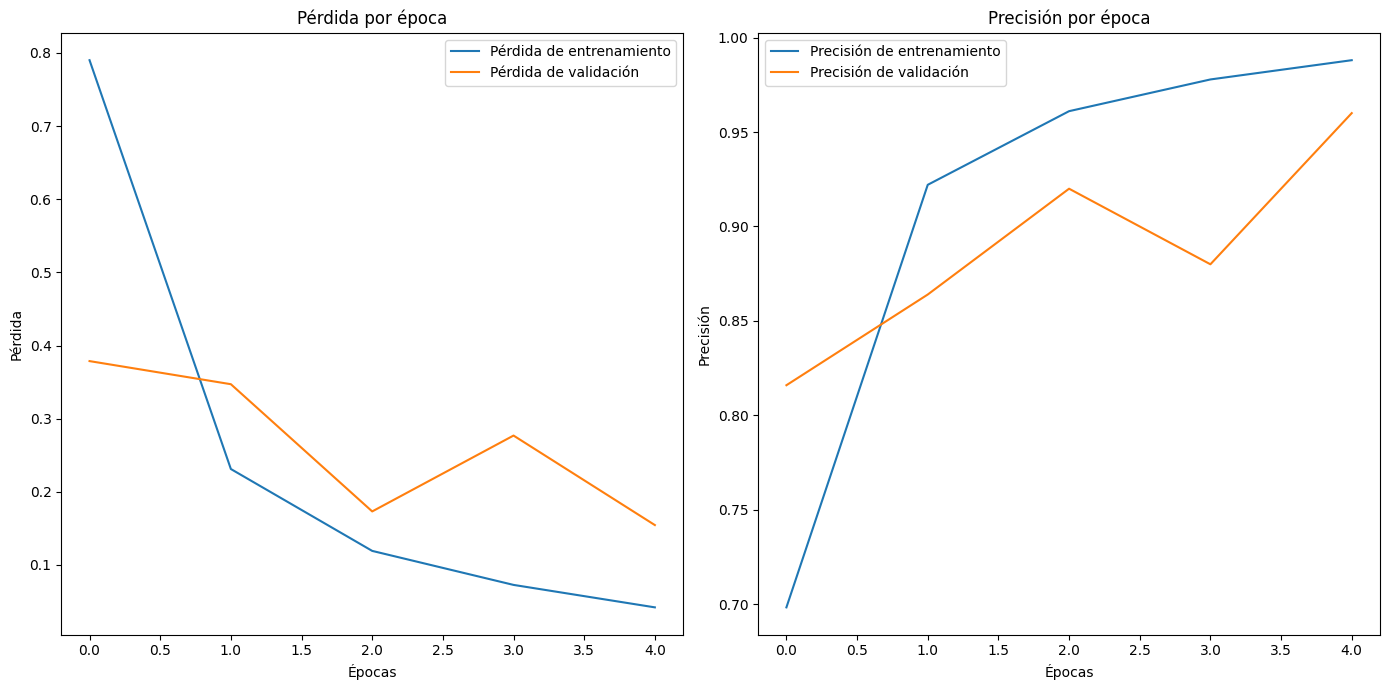

In [4]:
# Graficar las métricas de pérdida y precisión
plt.figure(figsize=(14, 7))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por época')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión por época')
plt.legend()

plt.tight_layout()
plt.show()

/home/jagomez/Development/repos/grocery_store/.venv/lib64/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_154. Received: the structure of inputs=('*',)
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 733ms/step
Accuracy: 0.97
Macro Precision: 0.96
Macro Recall: 0.97
Macro F1-Score: 0.97
Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-Score: 0.97

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       276
           1       0.99      0.97      0.98       153
           2       0.99      0.96      0.97       219
           3       0.99      0.91      0.95       164
           4       0.90      1.00      0.95       172
           5       0.93      1.00      0.96       100

    accuracy                           0.97      1084
   macro avg       0.96      0.97      0.97      1084
weighted avg       0.97      0.97      0.97      1084



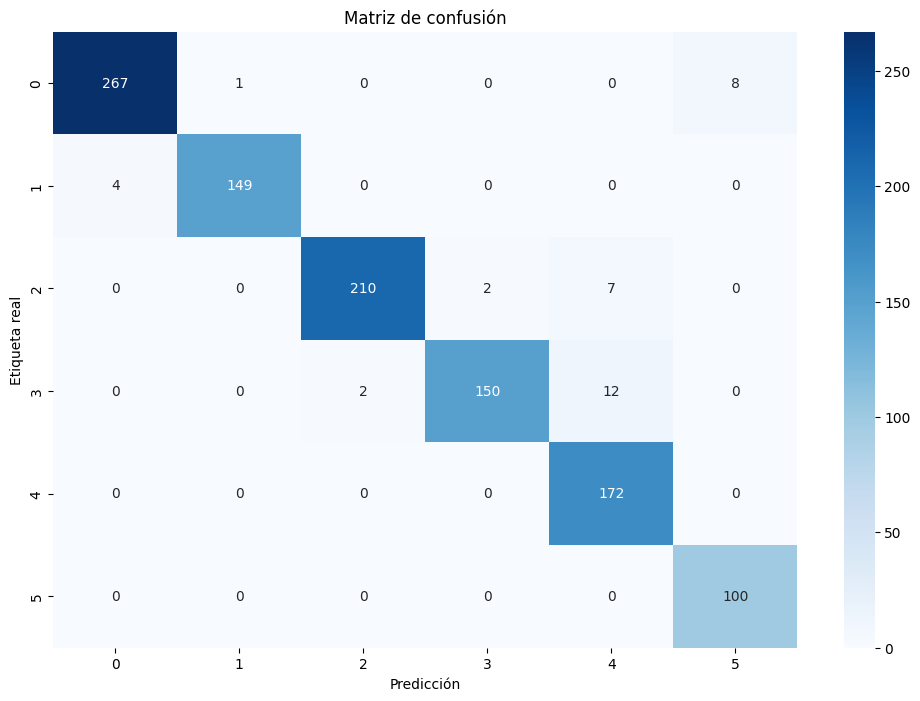

In [5]:
# Realizar predicciones
y_pred = model.predict([test_images])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Calcular métricas adicionales globales
accuracy = accuracy_score(test_labels, y_pred_classes)
precision_macro = precision_score(test_labels, y_pred_classes, average='macro')
recall_macro = recall_score(test_labels, y_pred_classes, average='macro')
f1_macro = f1_score(test_labels, y_pred_classes, average='macro')

precision_micro = precision_score(test_labels, y_pred_classes, average='micro')
recall_micro = recall_score(test_labels, y_pred_classes, average='micro')
f1_micro = f1_score(test_labels, y_pred_classes, average='micro')

# Imprimir métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro Precision: {precision_micro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Obtener todas las clases presentes en etiquetas reales y predicciones
all_classes = sorted(list(set(test_labels) | set(y_pred_classes)))

# Generar el reporte con etiquetas especificadas
report = classification_report(
    test_labels, 
    y_pred_classes, 
    labels=all_classes,  # Asegurarse de que incluya todas las clases
    target_names=[str(cls) for cls in all_classes]
)

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
print(report)

# Matriz de confusión (ajustada para incluir todas las clases)
conf_matrix = confusion_matrix(test_labels, y_pred_classes, labels=all_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(cls) for cls in all_classes],
            yticklabels=[str(cls) for cls in all_classes])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()

## Ajuste de hiperparametros, red neuronal MobileNetV2

In [6]:
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4), # Aumentando la regularizacion
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(len(set(balanced_train_labels)), activation='softmax')
])

# Compilar el modelo
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), # Reducir tasa de aprendizaje
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitorear la pérdida de validación
    patience=2,          # Detener si no mejora después de 2 épocas consecutivas
    restore_best_weights=True  # Restaurar los mejores pesos al final
)

# Entrenar el modelo
history = model.fit(
    balanced_train_images,
    balanced_train_labels,
    validation_data=(test_images, test_labels),
    epochs=5,
    batch_size = 16,
    callbacks=[early_stopping]
)

/tmp/ipykernel_7116/2814261141.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


Epoch 1/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 68s 609ms/step - accuracy: 0.3677 - loss: 3.2812 - val_accuracy: 0.8256 - val_loss: 2.0744
Epoch 2/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 522ms/step - accuracy: 0.6637 - loss: 2.1350 - val_accuracy: 0.9022 - val_loss: 1.5360
Epoch 3/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 55s 529ms/step - accuracy: 0.7515 - loss: 1.6439 - val_accuracy: 0.9373 - val_loss: 1.1965
Epoch 4/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 57s 543ms/step - accuracy: 0.8532 - loss: 1.2584 - val_accuracy: 0.9539 - val_loss: 0.9757
Epoch 5/5
105/105 ━━━━━━━━━━━━━━━━━━━━ 65s 618ms/step - accuracy: 0.8906 - loss: 1.0580 - val_accuracy: 0.9668 - val_loss: 0.8230


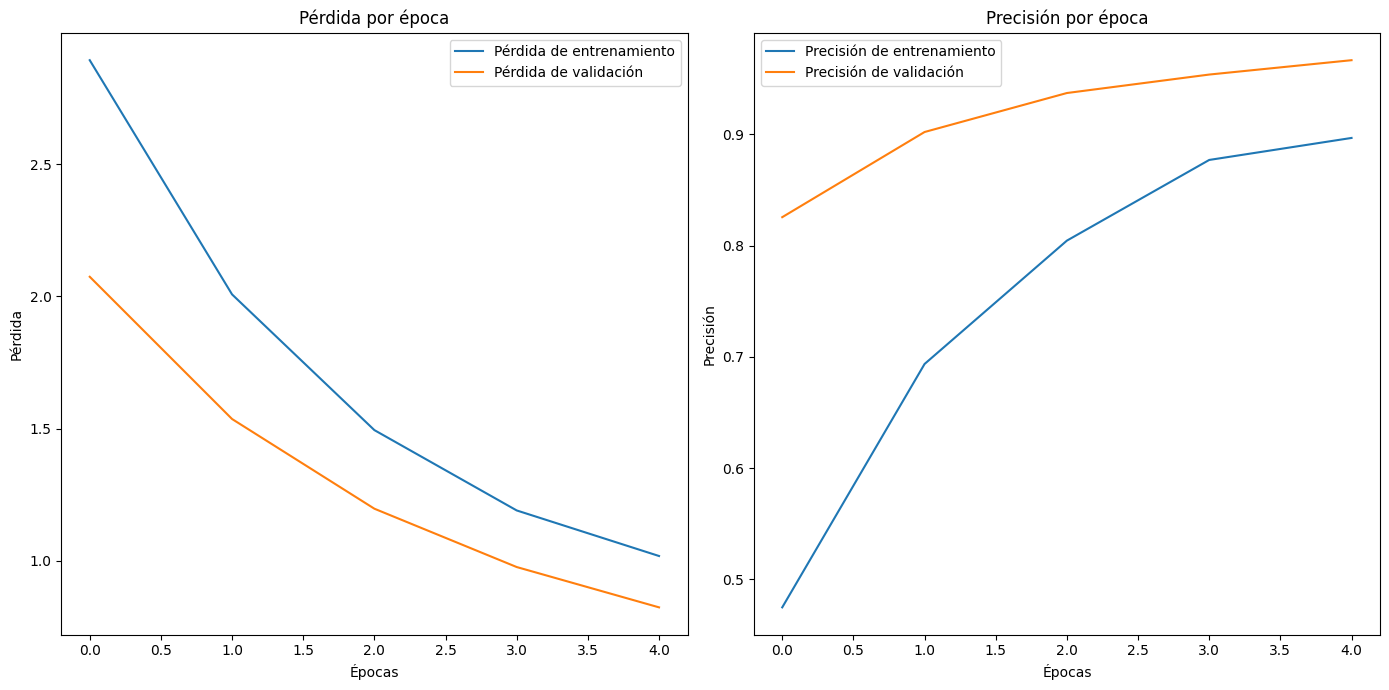

In [7]:
# Graficar las métricas de pérdida y precisión
plt.figure(figsize=(14, 7))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por época')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión por época')
plt.legend()

plt.tight_layout()
plt.show()

/home/jagomez/Development/repos/grocery_store/.venv/lib64/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: keras_tensor_316. Received: the structure of inputs=('*',)
  warnings.warn(


34/34 ━━━━━━━━━━━━━━━━━━━━ 25s 700ms/step
Accuracy: 0.97
Macro Precision: 0.97
Macro Recall: 0.97
Macro F1-Score: 0.97
Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-Score: 0.97

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       276
           1       1.00      0.95      0.98       153
           2       0.98      0.95      0.96       219
           3       0.94      0.93      0.93       164
           4       0.93      0.98      0.95       172
           5       0.98      1.00      0.99       100

    accuracy                           0.97      1084
   macro avg       0.97      0.97      0.97      1084
weighted avg       0.97      0.97      0.97      1084



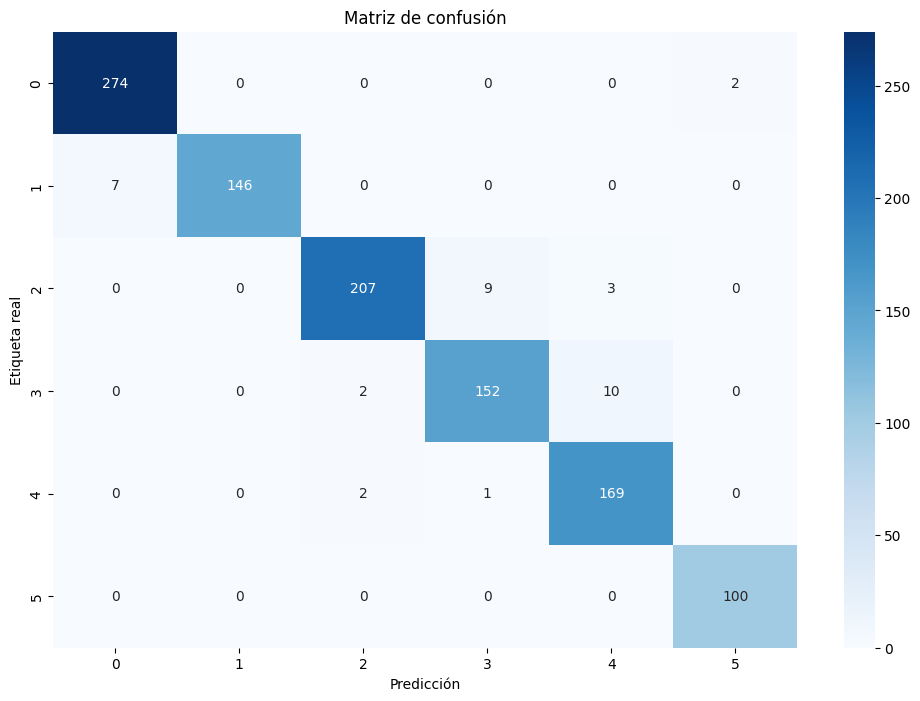

In [8]:
# Realizar predicciones
y_pred = model.predict([test_images])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Calcular métricas adicionales globales
accuracy = accuracy_score(test_labels, y_pred_classes)
precision_macro = precision_score(test_labels, y_pred_classes, average='macro')
recall_macro = recall_score(test_labels, y_pred_classes, average='macro')
f1_macro = f1_score(test_labels, y_pred_classes, average='macro')

precision_micro = precision_score(test_labels, y_pred_classes, average='micro')
recall_micro = recall_score(test_labels, y_pred_classes, average='micro')
f1_micro = f1_score(test_labels, y_pred_classes, average='micro')

# Imprimir métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro Precision: {precision_micro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Obtener todas las clases presentes en etiquetas reales y predicciones
all_classes = sorted(list(set(test_labels) | set(y_pred_classes)))

# Generar el reporte con etiquetas especificadas
report = classification_report(
    test_labels, 
    y_pred_classes, 
    labels=all_classes,  # Asegurarse de que incluya todas las clases
    target_names=[str(cls) for cls in all_classes]
)

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
print(report)

# Matriz de confusión (ajustada para incluir todas las clases)
conf_matrix = confusion_matrix(test_labels, y_pred_classes, labels=all_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(cls) for cls in all_classes],
            yticklabels=[str(cls) for cls in all_classes])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()

# Con estadísticas de imágenes

In [9]:
base_model_2 = tf.keras.applications.MobileNetV2(
    input_shape=(256, 256, 3),
    include_top=False,
    weights='imagenet'
)

/tmp/ipykernel_7116/2814119172.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_2 = tf.keras.applications.MobileNetV2(


In [10]:
train_stats_df = pd.DataFrame(train_detailed_stats)
test_stats_df = pd.DataFrame(test_detailed_stats)
val_stats_df = pd.DataFrame(val_detailed_stats)

In [11]:
# Rama de imágenes basada en el modelo base
image_input = Input(shape=(256, 256, 3), name="image_input")
image_branch = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5)
])(image_input)

stats_input = Input(shape=(train_stats_df.shape[1],), name="stats_input")
stats_branch = tf.keras.Sequential([
    Dense(128, activation='relu'),
    Dropout(0.5)
])(stats_input)
combined = concatenate([image_branch, stats_branch])
hidden_layer_3 = Dense(64, activation='relu', name="hidden_layer_1")(combined)  # Nueva capa oculta
hidden_layer_3 = Dropout(0.5, name="dropout_hidden_1")(hidden_layer_3)  # Regularización opcional

hidden_layer_4 = Dense(64, activation='relu', name="hidden_layer_2")(hidden_layer_3)  # Nueva capa oculta
hidden_layer_4 = Dropout(0.5, name="dropout_hidden_2")(hidden_layer_4)  # Regularización opcional


# Capa de salida
output = Dense(len(set(balanced_train_labels)), activation='softmax', name="output")(hidden_layer_4)

# Crear el modelo final
model_combined = Model(inputs=[image_input, stats_input], outputs=output)

# Compilar el modelo
model_combined.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
history_combined = model_combined.fit(
    [balanced_train_images, train_stats_df.to_numpy()], balanced_train_labels,
    validation_data=([val_images, val_stats_df.to_numpy()], val_labels),
    epochs=30,
    batch_size=16
)

Epoch 1/30


/home/jagomez/Development/repos/grocery_store/.venv/lib64/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'stats_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 353ms/step - accuracy: 0.2526 - loss: 1.8161 - val_accuracy: 0.6000 - val_loss: 1.1943
Epoch 2/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 37s 356ms/step - accuracy: 0.4733 - loss: 1.2466 - val_accuracy: 0.6160 - val_loss: 0.8750
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 398ms/step - accuracy: 0.5783 - loss: 0.9956 - val_accuracy: 0.6400 - val_loss: 0.7470
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 45s 429ms/step - accuracy: 0.6404 - loss: 0.7943 - val_accuracy: 0.7920 - val_loss: 0.6385
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 400ms/step - accuracy: 0.7078 - loss: 0.6954 - val_accuracy: 0.8080 - val_loss: 0.5748
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 42s 398ms/step - accuracy: 0.7336 - loss: 0.6025 - val_accuracy: 0.8800 - val_loss: 0.5099
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 393ms/step - accuracy: 0.7748 - loss: 0.5637 - val_accuracy: 0.8960 - val_loss: 0.4394
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 41s 392ms/step - accuracy: 0.7777 - loss: 0.5189 - val

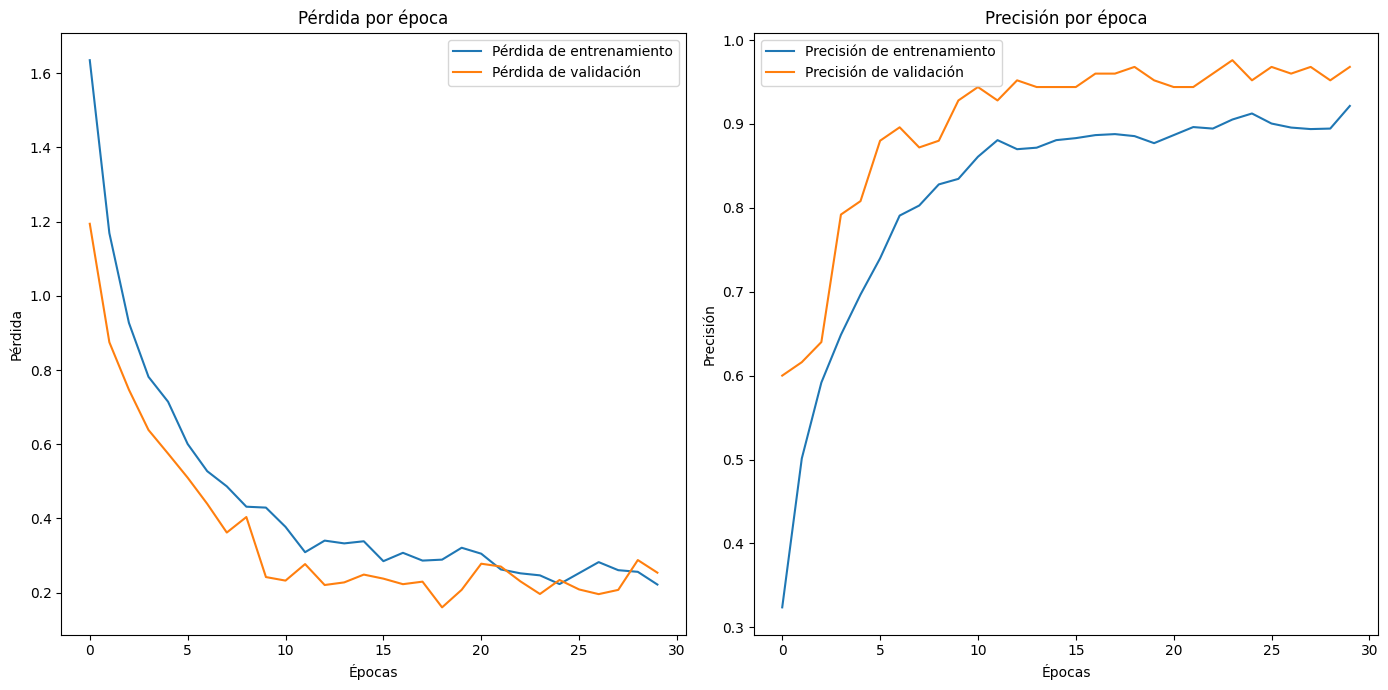

In [12]:
# Graficar las métricas de pérdida y precisión
plt.figure(figsize=(14, 7))

# Pérdida
plt.subplot(1, 2, 1)
plt.plot(history_combined.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_combined.history['val_loss'], label='Pérdida de validación')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.title('Pérdida por época')
plt.legend()

# Precisión
plt.subplot(1, 2, 2)
plt.plot(history_combined.history['accuracy'], label='Precisión de entrenamiento')
plt.plot(history_combined.history['val_accuracy'], label='Precisión de validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión por época')
plt.legend()

plt.tight_layout()
plt.show()

In [13]:
# Rama de imágenes basada en el modelo base
image_input = Input(shape=(256, 256, 3), name="image_input")
image_branch = tf.keras.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5)
])(image_input)

stats_input = Input(shape=(train_stats_df.shape[1],), name="stats_input")
stats_branch = tf.keras.Sequential([
    Dense(64, activation='relu'),
    Dropout(0.5)
])(stats_input)

combined = concatenate([image_branch, stats_branch])

hidden_layer_3 = Dense(64, activation='relu', name="hidden_layer_1")(combined)  # Nueva capa oculta
hidden_layer_3 = Dropout(0.5, name="dropout_hidden_1")(hidden_layer_3)  # Regularización opcional

hidden_layer_4 = Dense(64, activation='relu', name="hidden_layer_2")(hidden_layer_3)  # Nueva capa oculta
hidden_layer_4 = Dropout(0.5, name="dropout_hidden_2")(hidden_layer_4)  # Regularización opcional


# Capa de salida
output = Dense(len(set(balanced_train_labels)), activation='softmax', name="output")(hidden_layer_4)

# Crear el modelo final
model_combined = Model(inputs=[image_input, stats_input], outputs=output)

# Compilar el modelo
model_combined.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history_combined = model_combined.fit(
    [balanced_train_images, train_stats_df.to_numpy()], balanced_train_labels,
    validation_data=([val_images, val_stats_df.to_numpy()], val_labels),
    epochs=10,
    batch_size=16
)

Epoch 1/10


/home/jagomez/Development/repos/grocery_store/.venv/lib64/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['image_input', 'stats_input']. Received: the structure of inputs=('*', '*')
  warnings.warn(


105/105 ━━━━━━━━━━━━━━━━━━━━ 39s 325ms/step - accuracy: 0.2377 - loss: 1.9563 - val_accuracy: 0.6400 - val_loss: 1.1826
Epoch 2/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 49s 401ms/step - accuracy: 0.4920 - loss: 1.2462 - val_accuracy: 0.7600 - val_loss: 0.7692
Epoch 3/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 36s 347ms/step - accuracy: 0.6279 - loss: 0.8924 - val_accuracy: 0.8000 - val_loss: 0.5658
Epoch 4/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 38s 366ms/step - accuracy: 0.7031 - loss: 0.7187 - val_accuracy: 0.7840 - val_loss: 0.5017
Epoch 5/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 39s 369ms/step - accuracy: 0.7410 - loss: 0.6289 - val_accuracy: 0.8240 - val_loss: 0.4427
Epoch 6/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 39s 373ms/step - accuracy: 0.7979 - loss: 0.5027 - val_accuracy: 0.9280 - val_loss: 0.3062
Epoch 7/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 43s 411ms/step - accuracy: 0.8313 - loss: 0.4416 - val_accuracy: 0.8720 - val_loss: 0.3849
Epoch 8/10
105/105 ━━━━━━━━━━━━━━━━━━━━ 38s 365ms/step - accuracy: 0.8586 - loss: 0.3865 - val

34/34 ━━━━━━━━━━━━━━━━━━━━ 20s 572ms/step
Accuracy: 0.95
Macro Precision: 0.96
Macro Recall: 0.95
Macro F1-Score: 0.95
Micro Precision: 0.95
Micro Recall: 0.95
Micro F1-Score: 0.95

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       276
           1       0.99      0.93      0.96       153
           2       0.98      0.92      0.95       219
           3       0.88      0.96      0.92       164
           4       0.94      0.93      0.93       172
           5       0.99      0.99      0.99       100

    accuracy                           0.95      1084
   macro avg       0.96      0.95      0.95      1084
weighted avg       0.95      0.95      0.95      1084



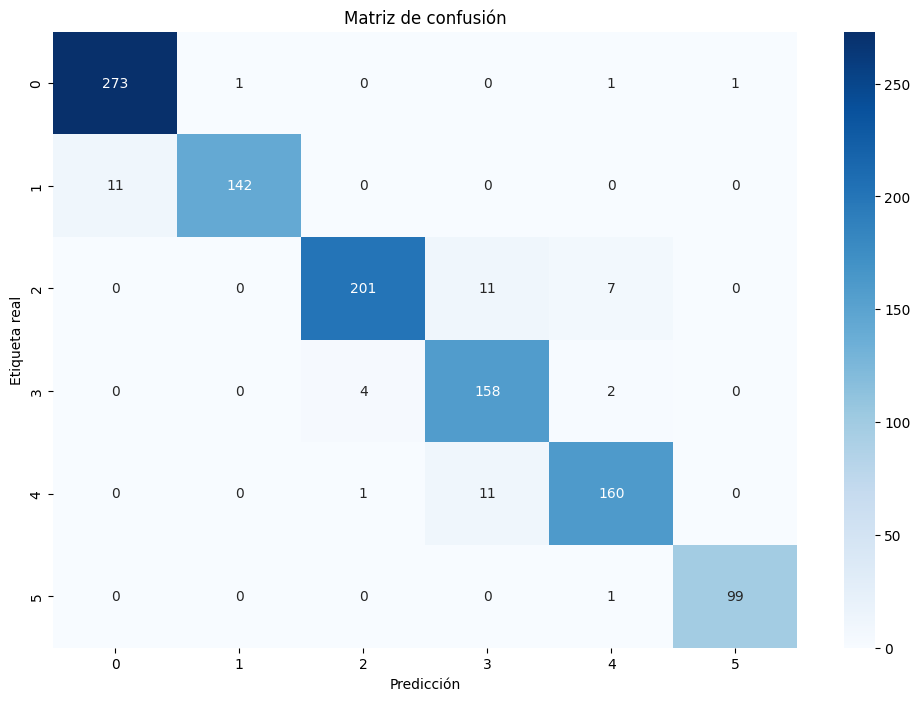

In [15]:
# Realizar predicciones
y_pred = model_combined.predict([test_images, test_stats_df])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Calcular métricas adicionales globales
accuracy = accuracy_score(test_labels, y_pred_classes)
precision_macro = precision_score(test_labels, y_pred_classes, average='macro')
recall_macro = recall_score(test_labels, y_pred_classes, average='macro')
f1_macro = f1_score(test_labels, y_pred_classes, average='macro')

precision_micro = precision_score(test_labels, y_pred_classes, average='micro')
recall_micro = recall_score(test_labels, y_pred_classes, average='micro')
f1_micro = f1_score(test_labels, y_pred_classes, average='micro')

# Imprimir métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro Precision: {precision_micro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Obtener todas las clases presentes en etiquetas reales y predicciones
all_classes = sorted(list(set(test_labels) | set(y_pred_classes)))

# Generar el reporte con etiquetas especificadas
report = classification_report(
    test_labels, 
    y_pred_classes, 
    labels=all_classes,  # Asegurarse de que incluya todas las clases
    target_names=[str(cls) for cls in all_classes]
)

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
print(report)

# Matriz de confusión (ajustada para incluir todas las clases)
conf_matrix = confusion_matrix(test_labels, y_pred_classes, labels=all_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(cls) for cls in all_classes],
            yticklabels=[str(cls) for cls in all_classes])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()

34/34 ━━━━━━━━━━━━━━━━━━━━ 21s 616ms/step
Accuracy: 0.97
Macro Precision: 0.97
Macro Recall: 0.97
Macro F1-Score: 0.97
Micro Precision: 0.97
Micro Recall: 0.97
Micro F1-Score: 0.97

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       276
           1       1.00      0.95      0.98       153
           2       0.98      0.95      0.96       219
           3       0.94      0.93      0.93       164
           4       0.93      0.98      0.95       172
           5       0.98      1.00      0.99       100

    accuracy                           0.97      1084
   macro avg       0.97      0.97      0.97      1084
weighted avg       0.97      0.97      0.97      1084



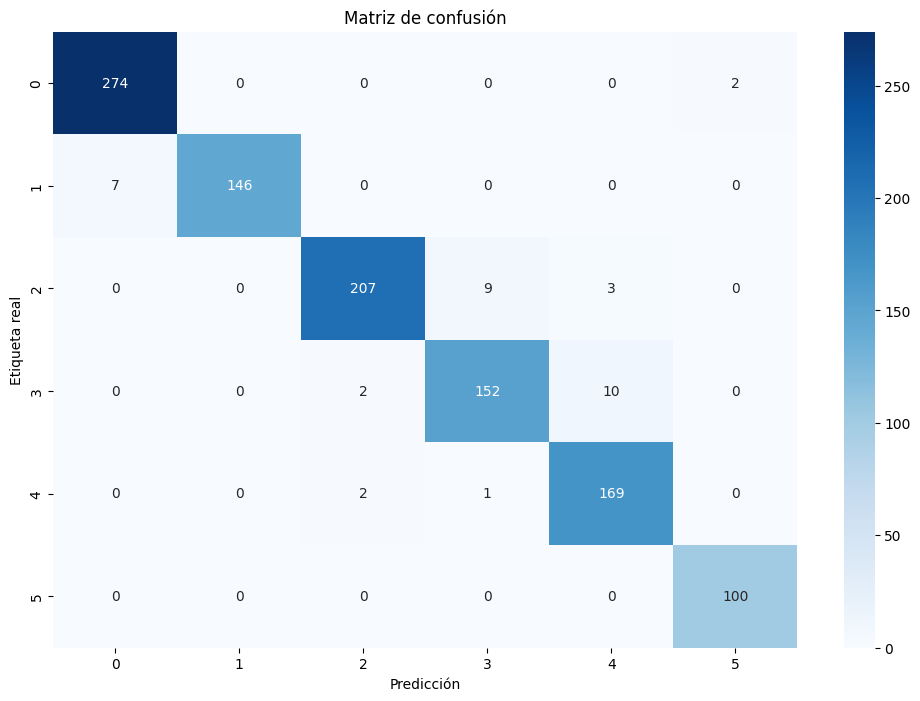

In [16]:
# Realizar predicciones
y_pred = model.predict([test_images])
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(test_labels, y_pred_classes)

# Calcular métricas adicionales globales
accuracy = accuracy_score(test_labels, y_pred_classes)
precision_macro = precision_score(test_labels, y_pred_classes, average='macro')
recall_macro = recall_score(test_labels, y_pred_classes, average='macro')
f1_macro = f1_score(test_labels, y_pred_classes, average='macro')

precision_micro = precision_score(test_labels, y_pred_classes, average='micro')
recall_micro = recall_score(test_labels, y_pred_classes, average='micro')
f1_micro = f1_score(test_labels, y_pred_classes, average='micro')

# Imprimir métricas globales
print(f"Accuracy: {accuracy:.2f}")
print(f"Macro Precision: {precision_macro:.2f}")
print(f"Macro Recall: {recall_macro:.2f}")
print(f"Macro F1-Score: {f1_macro:.2f}")
print(f"Micro Precision: {precision_micro:.2f}")
print(f"Micro Recall: {recall_micro:.2f}")
print(f"Micro F1-Score: {f1_micro:.2f}")

# Obtener todas las clases presentes en etiquetas reales y predicciones
all_classes = sorted(list(set(test_labels) | set(y_pred_classes)))

# Generar el reporte con etiquetas especificadas
report = classification_report(
    test_labels, 
    y_pred_classes, 
    labels=all_classes,  # Asegurarse de que incluya todas las clases
    target_names=[str(cls) for cls in all_classes]
)

# Imprimir el reporte de clasificación
print("\nReporte de clasificación:")
print(report)

# Matriz de confusión (ajustada para incluir todas las clases)
conf_matrix = confusion_matrix(test_labels, y_pred_classes, labels=all_classes)

# Graficar la matriz de confusión
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[str(cls) for cls in all_classes],
            yticklabels=[str(cls) for cls in all_classes])
plt.xlabel('Predicción')
plt.ylabel('Etiqueta real')
plt.title('Matriz de confusión')
plt.show()